Geospatial Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [3]:
link = ("/content/244400644_stationnements_cyclables.csv")
df = pd.read_csv(link,sep=';')
df.head()

,geo_point_2d,Geo Shape,id_local,id_osm,code_com,coordonneesxy,capacite,capacite_cargo,type_accroche,mobilier,...,couverture,surveillance,lumiere,url_info,d_service,source,proprietaire,gestionnaire,date_maj,commentaires
0,"47.24014209999996, -2.2782823","{""coordinates"": [-2.2782823, 47.24014209999996...",40,n1655161104,44184,"[-2.2782823000000034,47.24014210000001]",4,NaN,ROUE,ARCEAU,...,Faux,Faux,Faux,NaN,NaN,© les contributeurs d’OpenStreetMap ; © CARENE,NaN,NaN,2022-09-19,NaN
1,"47.275722860270285, -2.205563401614654","{""coordinates"": [-2.205563401614654, 47.275722...",82,n1655161426,44184,"[-2.2055634016146564,47.27572286027034]",6,NaN,CADRE ET ROUE,ARCEAU,...,Faux,Faux,Faux,NaN,NaN,© les contributeurs d’OpenStreetMap ; © CARENE,NaN,NaN,2022-09-19,NaN
2,"47.285041587733524, -2.225726700976113","{""coordinates"": [-2.225726700976113, 47.285041...",540,NaN,44184,"[-2.225726700976119,47.28504158773357]",2,NaN,CADRE,ARCEAU,...,Faux,Faux,Faux,NaN,NaN,© CARENE,NaN,NaN,2022-09-19,NaN
3,"47.297832194912985, -2.193971151595806","{""coordinates"": [-2.193971151595806, 47.297832...",544,NaN,44184,"[-2.193971151595806,47.29783219491302]",3,NaN,ROUE,ARCEAU,...,Faux,Faux,Faux,NaN,NaN,© CARENE,NaN,NaN,2022-09-19,"stationnement amovible, mis à dispo par la lav..."
4,"47.28585974973144, -2.195954751533444","{""coordinates"": [-2.195954751533444, 47.285859...",545,NaN,44184,"[-2.195954751533448,47.28585974973149]",30,NaN,ROUE,RATELIER,...,Vrai,Faux,Faux,NaN,NaN,© CARENE,NaN,NaN,2022-09-19,salariés des chantiers navals


In [17]:
# Check for rows with missing or malformed data in 'geo_point_2d'
df_invalid = df[df['geo_point_2d'].isnull() | ~df['geo_point_2d'].str.contains(',')]

# Display invalid rows
print(df_invalid[['geo_point_2d']])


Empty DataFrame
Columns: [geo_point_2d]
Index: []


In [18]:
# Split the 'geo_point_2d' column into latitude and longitude
df[['latitude', 'longitude']] = df['geo_point_2d'].str.split(',', expand=True)

# Convert latitude and longitude to float type
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)


In [19]:
# Check the first few rows of the new latitude and longitude columns
print(df[['latitude', 'longitude']].head())


    latitude  longitude
0  47.240142  -2.278282
1  47.275723  -2.205563
2  47.285042  -2.225727
3  47.297832  -2.193971
4  47.285860  -2.195955


### Basic Geospatial Visualization using Folium

In [6]:
# Initialize a Folium map at the mean of the latitude and longitude
map_center = [df['latitude'].mean(), df['longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for each parking location
for _, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['type_accroche']).add_to(folium_map)

# Display the map
folium_map


###Geospatial Aggregation

we will try to aggregate the geographic data by certain categories, such as municipality (code_com) or type of bicycle rack (type_accroche), to derive insights like:

How many parking facilities are in each municipality?
What types of racks are more common in certain geographic areas?

In [9]:
# Group by municipality and get the number of parking locations per municipality
parking_by_municipality = df.groupby('code_com').size()
parking_by_municipality


,0
code_com,
44013,7
44030,11
44052,12
44103,18
44132,109
44151,25
44168,9
44176,7
44184,376


In [8]:
# Group by type of rack and calculate the number of each type of rack per municipality
rack_by_municipality = df.groupby(['code_com', 'type_accroche']).size().unstack(fill_value=0)
rack_by_municipality

type_accroche,CADRE,CADRE ET ROUE,ROUE
code_com,,,
44013,0,3,4
44030,0,9,2
44052,2,0,10
44103,3,13,2
44132,10,91,8
44151,2,16,7
44168,0,7,2
44176,0,3,4
44184,36,320,20


### Static Geospatial Visualization with Geopandas

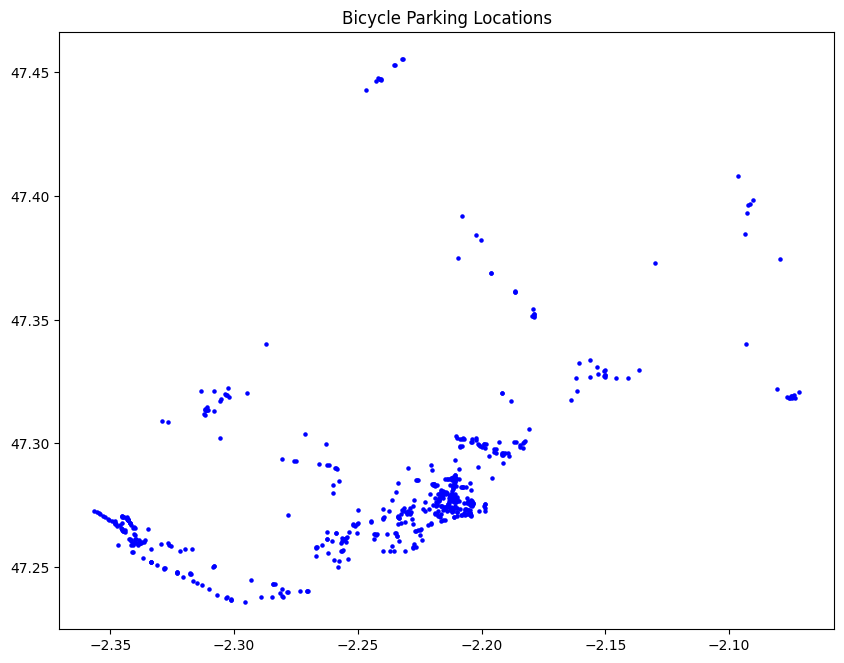

In [10]:
# Create a GeoDataFrame from the dataset
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

# Plot the locations on a map
gdf.plot(markersize=5, color='blue', figsize=(10, 10))
plt.title('Bicycle Parking Locations')
plt.show()


Conclusion:
This plot provides a clear geographic overview of where bicycle parking locations are concentrated, with a clear central hub of activity. The dense center indicates high parking demand or availability, while the more sparse distribution towards the edges represents areas with lower parking density.

Spatial Clustering

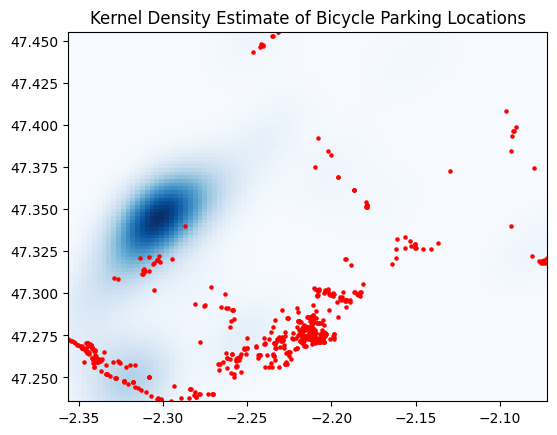

In [12]:
import geopandas.tools
from scipy import stats
import numpy as np

# Calculate kernel density estimate
x = df['longitude']
y = df['latitude']
kde = stats.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

# Plot the KDE results
plt.imshow(zi.reshape(xi.shape), origin='lower', cmap='Blues', extent=[x.min(), x.max(), y.min(), y.max()])
plt.scatter(df['longitude'], df['latitude'], s=5, color='red')
plt.title('Kernel Density Estimate of Bicycle Parking Locations')
plt.show()


###Key Points of Interpretation:
Dark Blue Region (High Density):

The darkest blue region represents the area where there is the highest concentration of bicycle parking locations. This suggests that a significant number of parking facilities are clustered in this area, likely a high-demand zone such as a city center or a commercial hub.
This concentrated region can indicate areas of heavy bicycle usage or regions where cycling infrastructure (like bike lanes or parking spots) is more prominent.
Light Blue Region (Moderate Density):

The lighter blue areas represent moderate densities of parking locations. These are still areas of interest with a reasonable number of parking facilities, but not as concentrated as the dark blue region.
These regions might be neighborhoods or secondary commercial areas with moderate bicycle traffic.
Red Points (Actual Parking Locations):

Each red dot represents an actual bicycle parking facility. The dots give you the precise locations of the parking spots and let you compare the KDE heatmap with the real distribution of points.
The scattered red dots in areas with no blue shading (no density) suggest that these are more isolated parking spots, perhaps located in suburban areas or areas with lower demand for bicycle parking.
White/Light Regions (Low Density or No Parking):

The white regions represent areas where either very few or no bicycle parking facilities exist. These gaps could be areas where parking is not provided or where demand for such infrastructure is very low.
These areas may represent suburban or rural parts of the map, or regions where bicycles are not a primary mode of transportation.
Conclusions:
The KDE shows a strong cluster of parking facilities in the dark blue region, highlighting the high demand for parking in that particular area.
The KDE smooths out the data to give you a clearer sense of where parking facilities are most concentrated, helping identify hotspots of cycling activity.
The spread of individual red dots indicates that bicycle parking is available in several less-dense areas as well, though the density decreases as you move away from the central cluster.

Proximity Analysis

In [13]:
from geopy.distance import geodesic

# Define a reference point (e.g., city center)
city_center = (47.240142, -2.278282)

# Calculate distance of each parking location to the city center
df['distance_to_center'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), city_center).km, axis=1)

# Get the closest parking locations to the city center
closest_parking = df.nsmallest(10, 'distance_to_center')
print(closest_parking[['id_local', 'distance_to_center']])


     id_local  distance_to_center
0          40            0.000025
342       584            0.030415
59        151            0.217324
499       585            0.240292
468        45            0.264848
140       263            0.271639
581        32            0.371064
294       170            0.527212
107       366            0.530941
337       559            0.550736


  i will Combining Geospatial Data with Other Variables
we  can combine spatial data with other variables to explore patterns, such as:

Capacity by location: Are areas with higher capacities clustered together?
Types of parking racks by area: Are certain rack types more common in particular areas?
For example:

In [14]:
# Plot capacity by location on the map
df['capacite'] = df['capacite'].fillna(0)  # Ensure no missing values for capacity
folium_map = folium.Map(location=map_center, zoom_start=12)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['capacite'] / 2,  # Adjust circle size based on capacity
        color='blue', fill=True, fill_opacity=0.6
    ).add_to(folium_map)
folium_map


###Capacity Utilization and Infrastructure Planning

Goals of Capacity Utilization and Infrastructure Planning:
Analyze Parking Capacity: Understand how much parking capacity is available in different areas and whether it meets the demand.
Identify High and Low Capacity Areas: Determine regions with either an abundance or shortage of parking capacity.
Assess Infrastructure Needs: Identify areas where more bicycle parking infrastructure may be needed, and areas where existing capacity might be underutilized.

Summarize Parking Capacity

In [4]:
# Summary statistics for parking capacity
print(df['capacite'].describe())


count    601.000000
mean       7.628952
std        5.392627
min        0.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       48.000000
Name: capacite, dtype: float64


Visualize Capacity Distribution

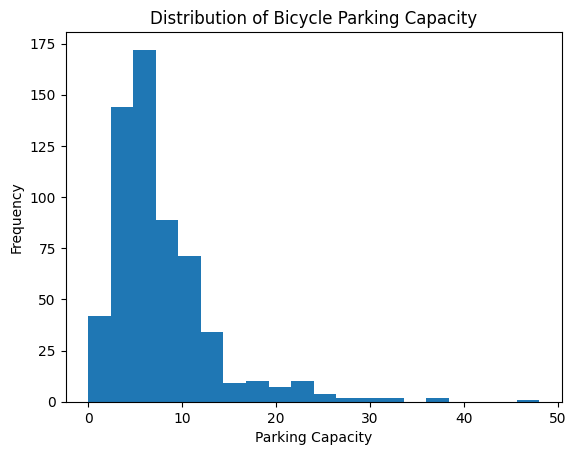

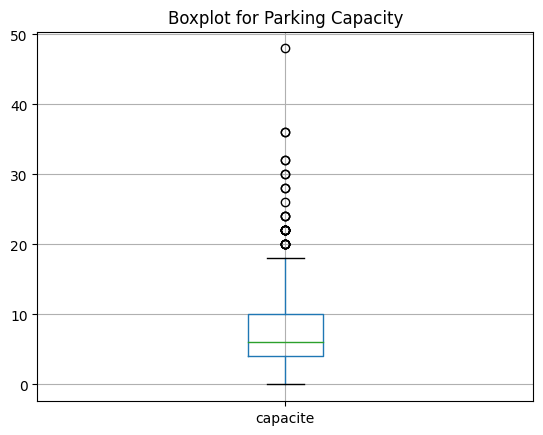

In [5]:
# Histogram of parking capacity
df['capacite'].plot(kind='hist', bins=20, title='Distribution of Bicycle Parking Capacity')
plt.xlabel('Parking Capacity')
plt.show()

# Boxplot to detect outliers in parking capacity
df.boxplot(column='capacite')
plt.title('Boxplot for Parking Capacity')
plt.show()


Key Insights:
Most Facilities Have Low Capacity:

The majority of parking facilities have a capacity of fewer than 10 bicycles, as seen from the first few bars. In fact, the highest frequency occurs around 5-7 parking spots, indicating that most bicycle parking locations are relatively small.
This suggests that parking facilities are widely distributed but generally provide limited capacity at each location.
Skewed Distribution:

The distribution is right-skewed, meaning that while there are many low-capacity parking facilities, there are very few large-capacity ones. The right tail extends to around 40-50 parking spots, but such facilities are rare.
This skewness is typical in infrastructure distributions, where many small-scale facilities support distributed demand, while only a few large hubs serve high-demand areas.
Few High-Capacity Facilities:

There are only a handful of locations that can hold 30 or more bicycles. These larger parking facilities are likely concentrated in high-demand areas, such as near public transport hubs, business districts, or key attractions.
Recommendations:
Infrastructure Planning: The dominance of small-capacity parking locations could suggest that while there is a widespread network of parking, the capacity at each site may be insufficient to handle peak demand in high-traffic areas. Consider increasing capacity at busy locations, especially where the utilization rate is high.

Addressing Demand Peaks: Since most facilities have fewer than 10 parking spots, planners should assess whether these are adequate for current demand, particularly in areas with expected growth in cycling traffic or tourist hotspots.

Focus on High-Capacity Facilities: The few high-capacity facilities could indicate key areas of bicycle use or need. Ensuring these areas are well-maintained and potentially expanding them could help improve the cycling infrastructure.

Group Capacity by Geographic Areas
Next, let's aggregate the capacity by geographic regions such as municipalities (code_com), to see how capacity is distributed across different areas.

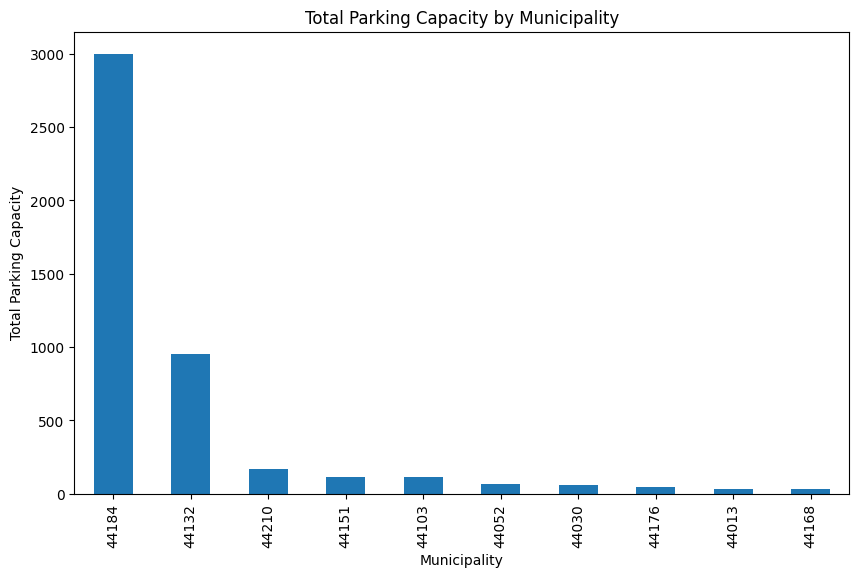

In [6]:
# Group by municipality and sum the parking capacity
capacity_by_municipality = df.groupby('code_com')['capacite'].sum()

# Sort and visualize the result
capacity_by_municipality.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title='Total Parking Capacity by Municipality')
plt.xlabel('Municipality')
plt.ylabel('Total Parking Capacity')
plt.show()


Key Insights:
Municipality 44184 Dominates:

Municipality 44184 has by far the largest total parking capacity, with over 3,000 bicycle parking spots. This municipality likely represents a central or highly urbanized area, possibly a city center or a transportation hub with heavy cycling demand.
The large difference between this municipality and others indicates that it has significantly more infrastructure in place to support cyclists.
Municipality 44132 is Next:

Municipality 44132 follows with over 1,000 bicycle parking spots, but it is still far behind Municipality 44184 in terms of total capacity.
This municipality could represent a secondary hub or another area with moderate cycling demand, but it doesn’t come close to the infrastructure seen in Municipality 44184.
Low Capacity Municipalities:

The remaining municipalities (like 44210, 44151, 44103, etc.) have much lower total bicycle parking capacities, all below 200 parking spots. These areas likely represent smaller towns, suburban areas, or regions where cycling is less popular or less supported by infrastructure.
The fact that these municipalities have such small capacities suggests potential room for improvement, especially if cycling is encouraged or infrastructure expansion is planned.
Recommendations:
Focus on High-Demand Areas (44184 & 44132):

Municipality 44184, with its large capacity, may already be well-equipped to handle current demand, but it's important to assess whether this infrastructure is being fully utilized. If there is overcrowding, further expansion may be needed.
Municipality 44132, although second in capacity, might still need infrastructure improvements if it's growing in popularity for cyclists. If demand is increasing, adding more parking might be necessary.
Identify Gaps in Lower-Capacity Areas:

For municipalities with low capacity (like 44210, 44151, and others), local authorities should assess whether the low capacity aligns with current demand or if infrastructure expansion could help. For example, adding more parking near schools, parks, or business districts could encourage more bicycle use.
Redistribute Resources:

If capacity utilization data is available, it would be beneficial to see if areas with lower demand have under-utilized infrastructure. In that case, reallocating resources (adding new parking spots) to underserved but high-demand areas could improve overall efficiency.


Identify Areas with Capacity Shortage

In [15]:
# Define a capacity threshold (e.g., less than 10 total parking spots)
low_capacity_municipalities = capacity_by_municipality[capacity_by_municipality < 100]

# Display the municipalities with low capacity
print(low_capacity_municipalities)


code_com
44013    33
44030    57
44052    65
44168    31
44176    48
Name: capacite, dtype: int64


Potential for Expansion:

Since these municipalities have fewer than 100 parking spots in total, it might be worth assessing whether additional parking infrastructure is needed, especially if these areas are growing or if there is an increase in cycling demand.
You could analyze further whether these areas are near public transport hubs, schools, or business centers where cycling demand is expected to be higher.

Visualization:
To better understand where these municipalities with low capacities are located, you can create a geographic map showing their locations and total capacities.

In [20]:
import folium

# Create a map centered at the mean latitude and longitude
map_center = [df['latitude'].mean(), df['longitude'].mean()]
capacity_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for low-capacity municipalities
for index, row in df[df['code_com'].isin([44013, 44030, 44052, 44168, 44176])].iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"Municipality: {row['code_com']}, Capacity: {row['capacite']}"
    ).add_to(capacity_map)

capacity_map


. Compare Capacity with Other Factors (e.g., Surveillance, Coverage)

In [21]:
# Group by municipality and calculate the average surveillance and coverage
facility_amenities = df.groupby('code_com').agg({
    'capacite': 'sum',
    'surveillance': lambda x: (x == 'Vrai').mean(),  # Proportion of facilities with surveillance
    'couverture': lambda x: (x == 'Vrai').mean()  # Proportion of facilities with coverage
})

# Display the results
print(facility_amenities)


          capacite  surveillance  couverture
code_com                                    
44013           33           0.0    0.000000
44030           57           0.0    0.000000
44052           65           0.0    0.166667
44103          114           0.0    0.111111
44132          949           0.0    0.073394
44151          116           0.0    0.120000
44168           31           0.0    0.000000
44176           48           0.0    0.000000
44184         3001           0.0    0.055851
44210          171           0.0    0.148148


Key Insights:
Lack of Surveillance Across All Municipalities:

All municipalities have a surveillance value of 0.0, meaning none of the parking facilities are equipped with surveillance. This could be a significant factor affecting security and usage, as cyclists may feel less secure parking their bicycles in unsupervised locations.
Improving surveillance infrastructure in high-traffic areas could encourage more bicycle usage.
Coverage Varies Across Municipalities:

Coverage values range from 0% to about 16.7%, meaning that only a small portion of the parking facilities in these municipalities are covered (protected from weather conditions like rain or sun).
Municipality 44052 has the highest proportion of covered parking spots at 16.7% of its total capacity.
The lowest coverage (0%) is observed in multiple municipalities, including 44013, 44030, 44168, and 44176.
High Capacity, Low Coverage Areas:

Municipality 44184 has the highest parking capacity (3,001 spots), but only 5.6% of its spots are covered, and none of them have surveillance.
Similarly, Municipality 44132 has a high total capacity of 949 spots, but only 7.3% of the parking facilities are covered. Again, there is no surveillance at all.
Low-Capacity, No Coverage Areas:

Several low-capacity municipalities, such as 44013 (33 spots), 44030 (57 spots), 44168 (31 spots), and 44176 (48 spots), not only have limited parking capacity but also no coverage or surveillance. These areas are likely underserved both in terms of capacity and the quality of infrastructure.
Key Takeaways and Recommendations:
Focus on High-Capacity Municipalities:

Municipalities 44184 and 44132 have the highest capacities but offer minimal coverage and no surveillance. These areas could benefit greatly from adding more covered parking spots and security measures. Given their large number of parking spots, improving infrastructure quality in these areas could have a significant positive impact on usage.
Improve Coverage in Low-Capacity Municipalities:

Municipalities with low capacities and 0% coverage (e.g., 44013, 44030, 44168, 44176) are likely underserved. Investing in more covered parking spots in these areas could encourage bicycle usage, especially in regions where weather conditions may discourage cyclists from using unprotected parking.
Address Lack of Surveillance:

The complete lack of surveillance across all municipalities might be a critical factor affecting the perception of security. Adding surveillance, even in key high-traffic areas, could improve the overall cycling experience and reduce the risk of theft or vandalism.
Targeted Infrastructure Improvements:

For municipalities like 44052 and 44103, which have low capacities but some degree of coverage, adding more covered spots and increasing the total capacity could make cycling more appealing in these areas.
The combination of low capacity and no coverage in several municipalities (e.g., 44168, 44176) suggests an urgent need for infrastructure development to meet potential demand.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   geo_point_2d    601 non-null    object 
 1   Geo Shape       601 non-null    object 
 2   id_local        601 non-null    int64  
 3   id_osm          439 non-null    object 
 4   code_com        601 non-null    int64  
 5   coordonneesxy   601 non-null    object 
 6   capacite        601 non-null    int64  
 7   capacite_cargo  1 non-null      float64
 8   type_accroche   601 non-null    object 
 9   mobilier        601 non-null    object 
 10  acces           601 non-null    object 
 11  gratuit         601 non-null    object 
 12  protection      601 non-null    object 
 13  couverture      589 non-null    object 
 14  surveillance    290 non-null    object 
 15  lumiere         290 non-null    object 
 16  url_info        10 non-null     object 
 17  d_service       11 non-null     flo

###Goals of Temporal Analysis:

Goals of Temporal Analysis:
Analyze Changes Over Time: Track when bicycle parking locations were last updated or modified to see if certain periods experienced more activity in terms of upgrades or expansions.
Detect Trends: Observe if there are any trends in infrastructure changes, such as more additions or maintenance activities during certain times of the year.
Evaluate Historical Growth: Understand the historical growth of bicycle parking infrastructure in the city or region, based on available data.
Key Dataset Columns for Temporal Analysis:
date_maj: This column contains the date when the parking infrastructure was last updated or modified, making it critical for any temporal analysis.
d_service: If available, this field may represent the date when the service was first introduced or launched.

In [26]:
df. date_maj

,date_maj
0,2022-09-19
1,2022-09-19
2,2022-09-19
3,2022-09-19
4,2022-09-19
...,...
596,2022-09-19
597,2022-09-19
598,2022-09-19
599,2022-09-19


In [27]:
# Convert 'date_maj' to datetime format
df['date_maj'] = pd.to_datetime(df['date_maj'], errors='coerce')

# Check if there are any invalid or missing dates after conversion
print(df['date_maj'].isnull().sum())


0


Analyze the Number of Updates Over Time

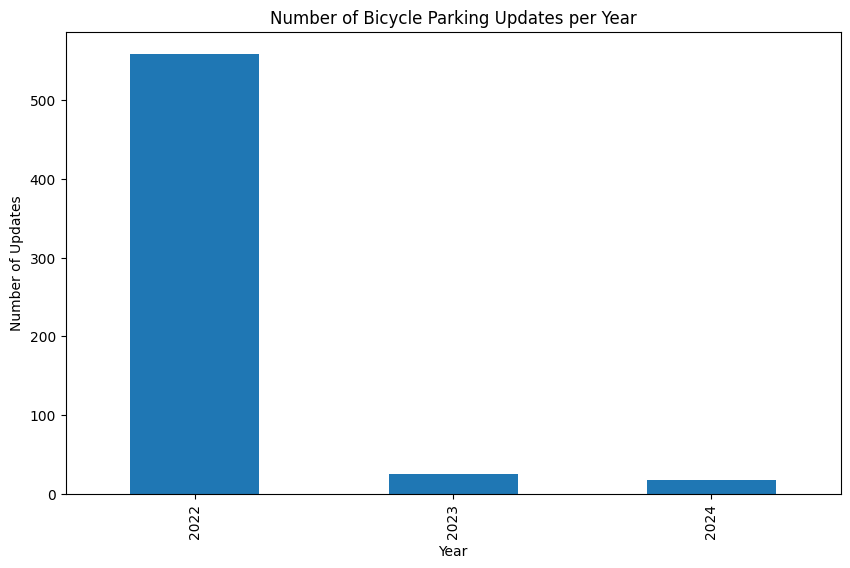

In [28]:
# Extract the year from 'date_maj'
df['year_maj'] = df['date_maj'].dt.year

# Count the number of updates per year
updates_per_year = df.groupby('year_maj').size()

# Plot the results
updates_per_year.plot(kind='bar', figsize=(10, 6), title='Number of Bicycle Parking Updates per Year')
plt.xlabel('Year')
plt.ylabel('Number of Updates')
plt.show()


Monthly Trends in Infrastructure Changes

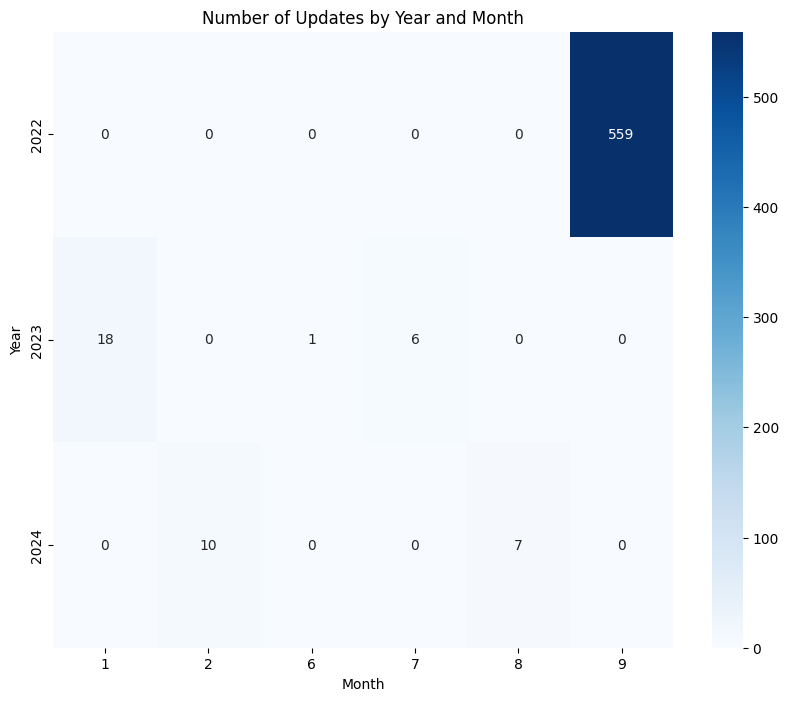

In [29]:
# Extract the month from 'date_maj'
df['month_maj'] = df['date_maj'].dt.month

# Count the number of updates by year and month
updates_by_month = df.groupby(['year_maj', 'month_maj']).size().unstack(fill_value=0)

# Plot a heatmap of updates by year and month
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(updates_by_month, cmap='Blues', annot=True, fmt='d')
plt.title('Number of Updates by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


Key Insights:
Major Activity in September 2022:

September 2022 stands out with 559 updates, which is significantly higher than any other month or year. This suggests a concentrated effort to either upgrade or introduce new bicycle parking infrastructure during this time.
This could indicate a major project or initiative that took place during this period, possibly to align with local cycling events or infrastructure development plans.
Steady Activity in Early 2023:

There is notable activity in January 2023, with 18 updates, and smaller spikes in March and June, with 1 and 6 updates, respectively.
These months seem to reflect regular maintenance or minor upgrades, possibly following the major activity in 2022.
Activity in Early 2024:

February 2024 saw 10 updates, followed by 7 updates in August 2024. This suggests ongoing infrastructure upgrades or maintenance but at a more moderate level compared to September 2022.
No Activity in Some Periods:

There are months with no updates recorded (such as all of 2022 except September, parts of 2023, and most of 2024). These could be either off-peak periods where no infrastructure changes were made, or it might suggest that updates are clustered around specific seasons or projects.
Temporal Patterns:
Peak in 2022: The high number of updates in September 2022 suggests a specific event or large-scale upgrade, while other months in 2022 saw no recorded activity. This could indicate that infrastructure updates are being concentrated within certain timeframes.

Moderate Activity in 2023 and 2024: The early months of 2023 and 2024 show some consistent activity, but it’s significantly lower than September 2022. This might reflect ongoing maintenance or smaller expansion efforts.

No Significant Seasonal Trend: While there are some updates in the early months of the year (January, February), there isn’t a clear seasonal pattern where updates always occur in specific months or seasons.

Recommendations:
Investigate the Surge in September 2022:

The large number of updates in September 2022 suggests a major project or event. It would be useful to investigate what caused this spike. Was it part of a large infrastructure project? Was it related to a cycling event or government initiative?
Regular Maintenance:

The updates spread across 2023 and 2024 suggest that some regular maintenance or incremental improvements are being made. However, compared to the September 2022 surge, the scale is much smaller, indicating that major overhauls may not be frequent.
Focus on Off-Peak Periods:

The months with no updates may represent off-peak periods where infrastructure changes are not necessary. Understanding the reasons behind the inactivity in these months (e.g., weather, budget cycles, etc.) could provide insights into planning future updates.

 Track Infrastructure Growth Over Time

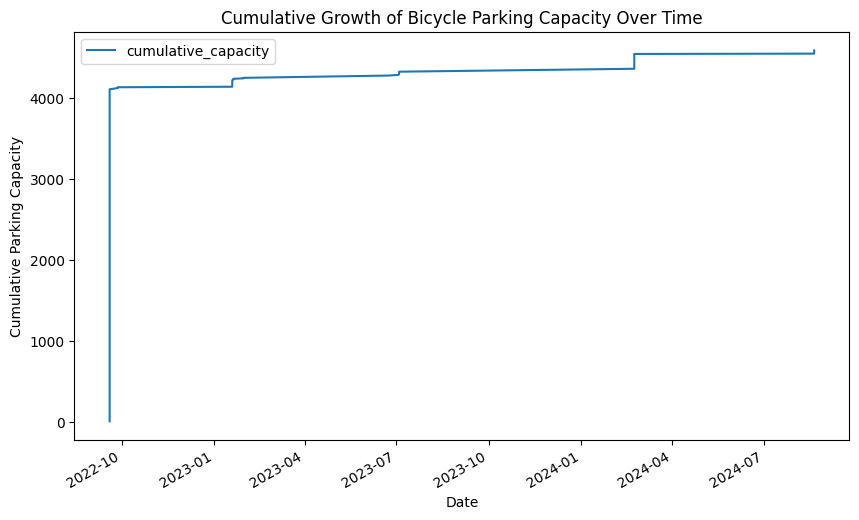

In [30]:
# Sort the data by 'date_maj'
df_sorted = df.sort_values('date_maj')

# Calculate the cumulative sum of capacities over time
df_sorted['cumulative_capacity'] = df_sorted['capacite'].cumsum()

# Plot the cumulative growth of parking capacity
df_sorted.plot(x='date_maj', y='cumulative_capacity', kind='line', figsize=(10, 6), title='Cumulative Growth of Bicycle Parking Capacity Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Parking Capacity')
plt.show()


Key Insights:
Sharp Increase in 2022:

There is a steep jump in cumulative capacity starting around September 2022, which aligns with the earlier observation from the heatmap where September 2022 saw a large number of updates (559 updates). This likely represents a major infrastructure expansion or a large project that added a significant amount of parking capacity all at once.
This sharp increase brings the cumulative capacity to just above 4,000 spots, showing that most of the current infrastructure was established during this period.
Steady Growth in 2023 and 2024:

After the large increase in late 2022, the growth in parking capacity slows down but continues at a steady pace throughout 2023 and into 2024.
The smaller steps in 2023 and 2024 reflect incremental additions or upgrades to bicycle parking, indicating ongoing efforts to maintain or expand the infrastructure, but at a much smaller scale compared to the large spike in 2022.
Plateaus in Growth:

There are plateaus where the cumulative capacity remains unchanged for several months, suggesting periods with no infrastructure updates or expansions.
For example, after the sharp rise in late 2022, the capacity remains mostly flat until mid-2023 when a small increase occurs. This indicates that large-scale infrastructure projects are not happening frequently, and changes are more sporadic.
Interpretation:
Most of the Growth Happened in 2022: The major expansion of bicycle parking capacity occurred in September 2022. This period likely represents a significant investment in cycling infrastructure, accounting for the bulk of the current capacity.
Slow but Consistent Additions: After the big increase in 2022, the infrastructure continues to grow slowly with occasional small increases, reflecting ongoing but less intense efforts to expand or maintain bicycle parking facilities.
Future Expansion Opportunities: If cycling demand is expected to increase, future infrastructure projects might need to target periods with no growth (plateaus) to keep up with the growing need for parking.
Recommendations:
Focus on Smaller Expansions: The consistent but smaller updates in 2023 and 2024 suggest that the infrastructure is being maintained or expanded incrementally. Planning for more frequent or larger capacity expansions could help meet future cycling demands.
Identify Growth Drivers: Investigate what led to the significant growth in September 2022—was it a policy initiative, a major event, or an infrastructure project? Understanding this can help replicate similar success in future expansions.
Plan for Upcoming Cycles: If this trend holds, you might expect another period of growth in the near future. Planning for another major expansion could be beneficial, especially in under-served areas.

5. Assess the Frequency of Maintenance and Updates

In [31]:
# Group by 'id_local' to calculate the time between updates for each parking location
df['time_since_last_update'] = df.groupby('id_local')['date_maj'].diff()

# Analyze the average time between updates
avg_time_between_updates = df['time_since_last_update'].mean()

print(f"Average time between updates for parking locations: {avg_time_between_updates}")


Average time between updates for parking locations: NaT


In [32]:
# Check how many updates exist for each location
updates_per_location = df.groupby('id_local')['date_maj'].count()

# Display locations with only one update
single_update_locations = updates_per_location[updates_per_location == 1]
print(f"Locations with only one update:\n{single_update_locations}")


Locations with only one update:
id_local
1      1
3      1
6      1
8      1
9      1
      ..
667    1
670    1
671    1
672    1
675    1
Name: date_maj, Length: 601, dtype: int64


In [33]:
# Check for missing or invalid dates in the 'date_maj' column
missing_dates = df['date_maj'].isnull().sum()
print(f"Number of missing or invalid dates: {missing_dates}")

# Remove rows with missing dates if necessary
df_cleaned = df.dropna(subset=['date_maj'])


Number of missing or invalid dates: 0


In [34]:
# Calculate time since last update for each location
current_date = pd.to_datetime('today')
df['time_since_last_update'] = current_date - df['date_maj']

# Display the average time since the last update for all locations
avg_time_since_last_update = df['time_since_last_update'].mean()
print(f"Average time since the last update for all locations: {avg_time_since_last_update}")


Average time since the last update for all locations: 740 days 08:35:47.448171720


 Compare Temporal Data with Other Factors

In [35]:
# Group by 'couverture' and 'surveillance' and analyze the average date of updates
avg_update_by_coverage = df.groupby('couverture')['date_maj'].mean()
avg_update_by_surveillance = df.groupby('surveillance')['date_maj'].mean()

print(f"Average update date for parking with coverage:\n{avg_update_by_coverage}")
print(f"Average update date for parking with surveillance:\n{avg_update_by_surveillance}")


Average update date for parking with coverage:
couverture
Faux   2022-10-01 08:00:00
Vrai   2023-03-28 00:00:00
Name: date_maj, dtype: datetime64[ns]
Average update date for parking with surveillance:
surveillance
Faux   2022-11-06 15:18:37.241379328
Name: date_maj, dtype: datetime64[ns]


 Seasonal Trends in Updates or Additions

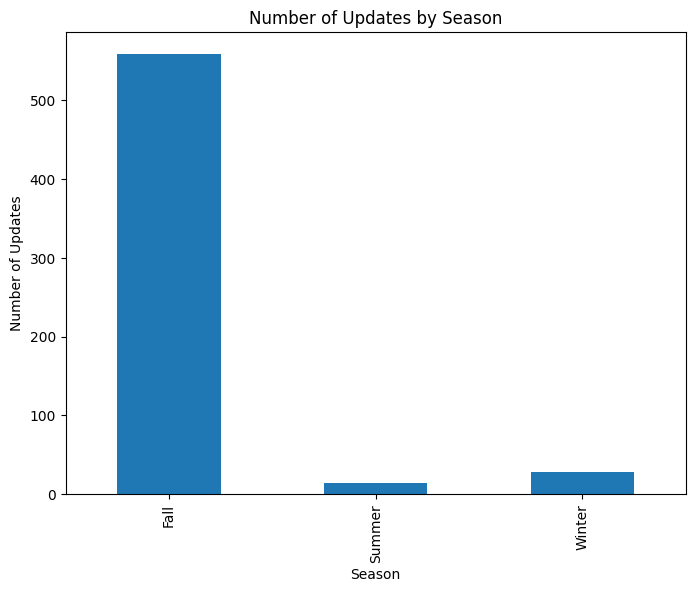

In [36]:
# Extract the season based on the month
df['season'] = df['month_maj'].apply(lambda x: 'Spring' if x in [3, 4, 5] else
                                                  'Summer' if x in [6, 7, 8] else
                                                  'Fall' if x in [9, 10, 11] else 'Winter')

# Count the number of updates per season
updates_per_season = df.groupby('season').size()

# Plot the results
updates_per_season.plot(kind='bar', figsize=(8, 6), title='Number of Updates by Season')
plt.xlabel('Season')
plt.ylabel('Number of Updates')
plt.show()


Key Insights:
Fall Dominates Updates:

The vast majority of updates occur during Fall (over 500 updates), which suggests that infrastructure upgrades and modifications are heavily concentrated in this season. This could be due to a planned maintenance cycle, weather conditions, or an infrastructure expansion project that took place in Fall (especially considering the spike in September 2022 noted earlier).
This likely reflects a seasonal trend where the majority of changes to parking facilities are made before winter, potentially to prepare for the upcoming colder months.
Minimal Activity in Summer and Winter:

Summer and Winter show very low update activity, with only a few updates recorded in each season. This indicates that either:
These seasons might not be ideal for construction or infrastructure updates, perhaps due to unfavorable weather conditions.
There might be a planned focus on maintaining or upgrading infrastructure during the Fall and keeping minimal activity during other seasons.
Lack of Updates in Spring:

Interestingly, there are no updates during Spring in this data. Spring might generally be seen as a time for increased cycling activity, yet no updates are being made in this season. It's possible that infrastructure is already set up in Fall and maintained throughout Spring without additional upgrades.
Potential Reasons for Fall Dominance:
Preparation for Winter: It's possible that most updates happen in Fall to ensure the infrastructure is ready for winter, especially in regions where weather conditions might negatively impact parking facilities (e.g., snow or rain).
End-of-Year Budget Cycles: In some cities, infrastructure projects may ramp up in the latter half of the year due to budget allocations, leading to concentrated updates in Fall.
Recommendations:
Evaluate the Need for Spring Updates:

Given the lack of updates in Spring, it may be useful to assess whether the infrastructure is adequately prepared for the increase in cycling that often happens in Spring. If demand rises during this season, it might be worth considering additional maintenance or updates before the cycling season starts.
Consider Spreading Updates Throughout the Year:

If possible, spreading the updates across more seasons (especially Spring) could help distribute the workload and ensure infrastructure is well-maintained throughout the year, rather than focusing updates only in Fall.
Investigate the Fall Spike:

The extremely high number of updates in Fall (especially from September 2022) suggests a concentrated project or initiative. Understanding what caused this spike could provide valuable insights for future planning cycles.

####Categorical Analysis

####. Missing Data Analysis

####Correlation Analysis

 Comparative Analysis